In this notebook I'm going to analyse the tweet collected and the the most used hashtags by congolese on twitter
For now a simple defintion of a congolese on social media is someone who tweet using the following hashtags : DRC, RDC, RDCongo, DRCongo.

In [1]:
import sys
from collections import Counter, defaultdict
import json

Let analyse a tweet and get the hashtags involed in the tweet

In [2]:
def get_hashtags(tweet):
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])
    return [ get_text(tag) for tag in hashtags if get_text(tag) not in ['rdc', 'drc', 'rdcongo', 'drcongo']]

In [3]:
def get_text(tag):
    return tag.get('text').lower()

In [6]:
with open('../data/query_drc.jsonl' , 'r') as f :
    hastags = Counter()
    for line in f:
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        hastags.update(hashtags_in_tweet)
    for tag,count in hastags.most_common(25):
        print("{} : {}".format(tag, count))

kinshasa : 77
tshisekedi : 52
ebola : 50
ébola : 22
lualaba : 12
kalemie : 12
quota100 : 11
congo : 11
braintumors : 11
mobutu : 7
urgent : 7
avendre : 7
monusco : 7
governo : 7
butembo : 6
expulsion : 6
mort : 6
rétention : 6
afrique : 6
kabila : 6
raïs : 6
kin : 6
genderpolicy : 5
tanzania : 5
tanganyika : 5


let check how our people uses others hastags apart from the one I selected 

In [7]:
with open('../data/stream_DRC_RDC_DRCongo_RDCongo.jsonl' , 'r') as f :
    hashtag_count = defaultdict(int)
    for line in f :
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        n_of_hashtags = len(hashtags_in_tweet)
        hashtag_count[n_of_hashtags] +=1
        tweet_with_hashtags = sum([count for n_of_tags , count in hashtag_count.items() if n_of_tags>0])
        tweet_without_hashtags = hashtag_count[0]
        total_tweet = tweet_with_hashtags + tweet_without_hashtags
print("{} tweets without hashtags  ({}%)".format(tweet_without_hashtags,  tweet_without_hashtags*100/total_tweet)) 
print("{} tweets with at least one hashtag  ({}%)".format(tweet_with_hashtags,  tweet_with_hashtags*100/total_tweet))        

146 tweets without hashtags  (75.25773195876289%)
48 tweets with at least one hashtag  (24.742268041237114%)


Conclusion we can see that we have only 92 tweets without hashtags 

### II. Tweet text analysis

In this portion of the notebook we will analyse a tweet as text and perform some NLP tasks on it such tokenization, etc

In [8]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [9]:
def process_text(text, tokenizer= TweetTokenizer(), words_to_remove=[]):
    """
    Process the text of a tweet
    - lowertext
    - stop world 
    - digit removal
    and return a list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in words_to_remove and not token.isdigit()]
    

let do the analysis now

In [10]:
tweet_tokenizer = TweetTokenizer()
punctuation  = list(string.punctuation)
stop_word_list_english = stopwords.words('english')
stop_word_list_french = stopwords.words('french')
others_words = ['rt', 'via', '...', '…', '»:', '«:' , '’:', 'les']
words_to_remove = punctuation + stop_word_list_english + stop_word_list_french + others_words

In [12]:
term_counts = Counter()
with open('../data/query_drc.jsonl' , 'r') as f :
    for line in f:
        tweet = json.loads(line)
        tokens = process_text(text=tweet.get('text'), tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    for tag, count in term_counts.most_common(20):
        print("{}: {}".format(tag, count))

#rdc: 511
rdc: 305
’: 301
tshisekedi: 250
@presidence_rdc: 220
journée: 143
@fatshi13: 138
mai: 138
jeudi: 130
⁦: 118
payée: 116
⁩: 113
chômée: 104
#drc: 102
@topcongo: 98
e: 92
drc: 86
obsèques: 84
déclarée: 84
#kinshasa: 77


We can see that we need to update our list of stop words and punctuations world like '»:', '»:' , '’:' should be removed

For now we can remove them manually , and next time we will find a way to deal wit those kind of puctuation as weel as contractions

#### III. Term frequency

*The following graph will plot the term frequency of words vs his position within the ranking term*

In [13]:
y = [count for tag, count in term_counts.most_common(100)]
x = range(1, len(y)+1)

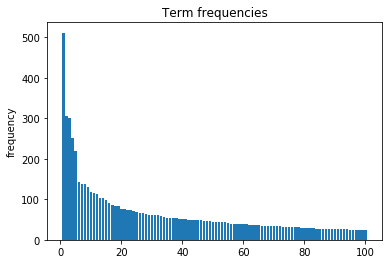

In [14]:
plt.bar(x, y)
plt.title("Term frequencies")
plt.ylabel('frequency')
plt.savefig('../images/term_distribution.png')

How can we explain this figure?
The figure shows a long tail, it can be explain with the fact the a small pottion of frequent item dominate the distribution, and . there is a large number of item with low frequency. This can also be explained as the **80-20** rule.

### III. Time series analysis 

Basically in this  section we will use the field `created_at` of a tweet and answer to this question:
**at what time congolese use twitter the most?**, the answer to this question can be usefull when we want to know when to tweet to reach a maximum audiance.

In [15]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

In [16]:
def read_tweets_file(path):
    """
    a genrator function which read a json file of tweets and return a iterator of this content file by line
    param:
    path : json file path
    """
    with open(path, 'r') as f :
        for line in f:
            tweet = json.loads(line)
            yield tweet

In [21]:
all_dates = list()
for tweet in read_tweets_file('../data/query_drc.jsonl'):
    all_dates.append(tweet.get('created_at'))
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(idx))
one_second_series = pd.Series(ones, index=idx)

Downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin.
Basically this helps us to know how many tweet we have in one minute time slot.

In [22]:
per_minute = one_second_series.resample('1Min').apply(sum).fillna(0)

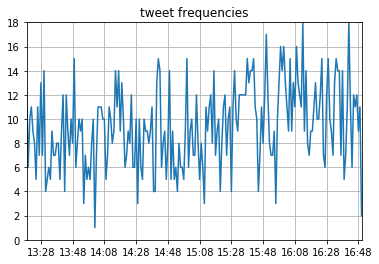

In [25]:
fig, ax=plt.subplots()
ax.grid(True)
ax.set_title('tweet frequencies')
hours = mdates.MinuteLocator(interval=20)
date_formatter = mdates.DateFormatter('%H:%M')
max_date = idx.max()
min_date = idx.min()
max_freq = per_minute.max()
ax.set_ylim(0,  max_freq)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(min_date, max_date)
ax.plot(per_minute.index, per_minute)
plt.savefig('../images/tweet_per_time.png')

We can see from the figure that our tweet were collected from a 30 minutes time intervales (18:00-18:30) and we have the pick time at 18:19 with more that 14 tweets.
Since our time slot was too small we can't find when congolese tweet a lot , but the procedure is set.
If we had more tweet we could estimate with accuracy when the congolese tweet the most and advice some buisness to tweet a lot in that time.

### IV. Create a WordCloud

A wordcloud is a image which looks like a cloud filled with word where the word size is proportional to the frequency of word in a list of words.

We can also say : 
WordCloud is a technique to show which words are the most frequent among the given text.

let install the package 

In [26]:
#!pip install WordCloud

In [27]:
from wordcloud import WordCloud
import matplotlib.colors as colors

we will use our `term_count`counter to generate the world cloud 

In [28]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',normalize_plurals=True).generate_from_frequencies(term_counts)

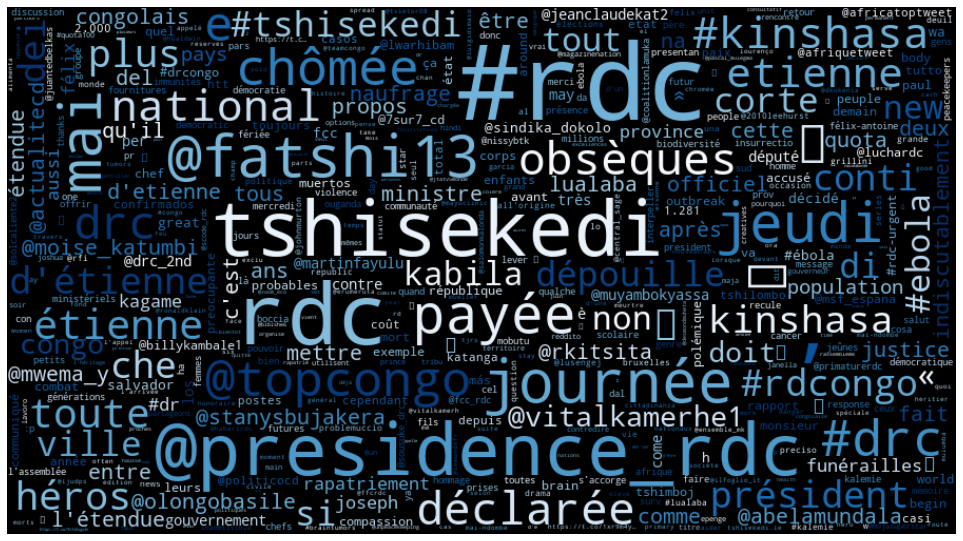

In [29]:
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us try to create a color map with DRC flag to make the wordcount made with DRC colors to see what will happen.

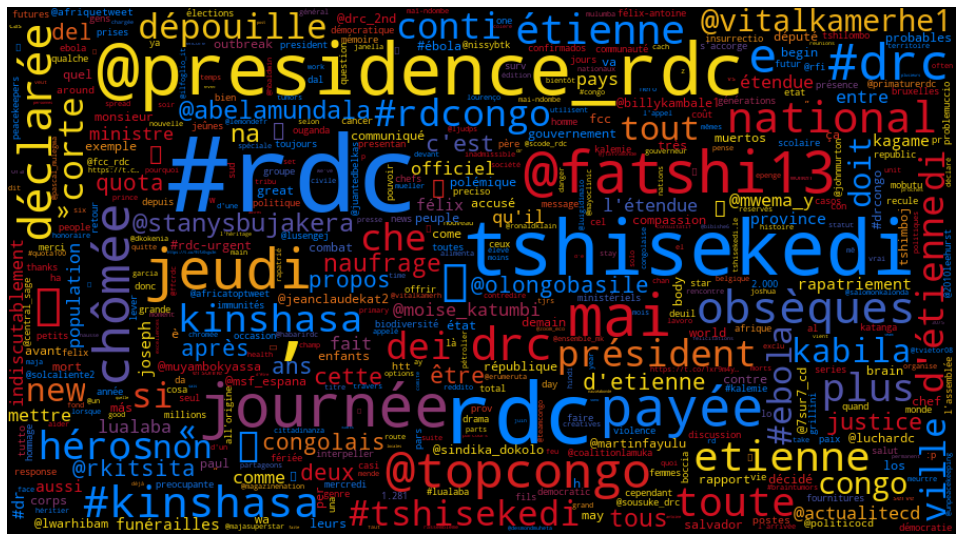

In [30]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap=drc_flag_color_map,normalize_plurals=True).generate_from_frequencies(term_counts)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### V. Improvement ton twitter preprocessing 

In [33]:
import re
import preprocessor as tweet_preprocessor
import unicodedata
import many_stop_words

As you can see from the wordcount we find meaningless words, ie (c'est, different word counts for a word with hashtag and without hashtag, twitter handles(Idon't know yet if I should remove them or not))
We can use the approachs form [this blogpost](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf) to refractor our cleaning process.
- the first approach was to use a thrid part libary to clean the tweet. all the cleaning process are done in background with that libray. The library is called : *[tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/)*
- the second approach was to use additional steps after the normal prepocessin we didd, those steps are (emoji removals, replacing consecutives ascii char with spaces)f
- another prepocessing approach to do is to consider the fact that we are dealing with french tweets, we need to do some prepocessing due to the complexity of that language.
- I will also remove the # from the hashtags

In [34]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', '’:'
    ])
emoticons = emoticons_happy.union(emoticons_sad)
# let append emoticons to words_to remove

words_to_remove = set(words_to_remove).union(emoticons)

In [35]:
len(words_to_remove)

437

let remove also the emojis

In [36]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [37]:
def remove_nonlatin(s): 
    """
    remove non ascii character but keep accent
    """
    s = (ch for ch in s
         if unicodedata.name(ch).startswith(('LATIN', 'DIGIT', 'SPACE')))
    return ''.join(s)

In [38]:
def remove_emoji(text):
    """
    remove the emojis and non ascii char with space from the tweet
    """
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = ' '.join(re.findall(r'[\u0020-\u007F\u00A0-\u00FF\u0100-\u017F\u0180-\u024F]+', text))
    #remove emojis from tweet
    text = emoji_pattern.sub(r'', text)
    return text

Here is the final normalization process:
- remove_using_library
- remove_emoji()
- process_text()
- french_additional_step()

Let do it 

In [41]:
# I decide to keep mentions and hashtags
tweet_preprocessor.set_options(tweet_preprocessor.OPT.URL, 
                               tweet_preprocessor.OPT.EMOJI,
                               tweet_preprocessor.OPT.RESERVED,
                               tweet_preprocessor.OPT.EMOJI, 
                               tweet_preprocessor.OPT.SMILEY,
                               tweet_preprocessor.OPT.NUMBER)

- let apply french additionnal step by removing the stops word we have , we will use an addional library
add additional french word in list of word to remove

In [42]:
words_to_remove = words_to_remove.union(set(many_stop_words.get_stop_words('FR')))

In [43]:
def get_term_count(path):
    """
    preporcess and return terms count from a file of tweets.
    Parm :
    path:  string : the path of the tweet files
    return a dictionary of term and the count of they occurences
    """
    term_counts = Counter()
    for tweet in read_tweets_file(path):
        text = tweet_preprocessor.clean(tweet.get('text'))
        text = text.replace('#', '')
        text = remove_emoji(text)
        tokens = process_text(text=text, tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    return term_counts

In [45]:
for tag, count in get_term_count('../data/query_drc.jsonl').most_common(5):
    print("{}: {}".format(tag, count))

rdc: 790
tshisekedi: 302
@presidence_rdc: 220
drc: 191
journée: 143


#### Ploting the wordcount graph again.

In [87]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
def generate_word_cloud(term_counts, color_map):
    return WordCloud(width=900,
                     height=500,
                     max_words=500,
                     max_font_size=100,
                     relative_scaling=0.5,
                     colormap=color_map,
                     normalize_plurals=True).generate_from_frequencies(term_counts)
def plot_word_cloud(word_cloud):
    plt.figure(figsize=(17,14))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.savefig('../images/DRC_WORD_COUNT.png')
    plt.axis("off")
    plt.show()

In [88]:
term_counts['ebola'] = term_counts['ebola']+ term_counts['ébola']

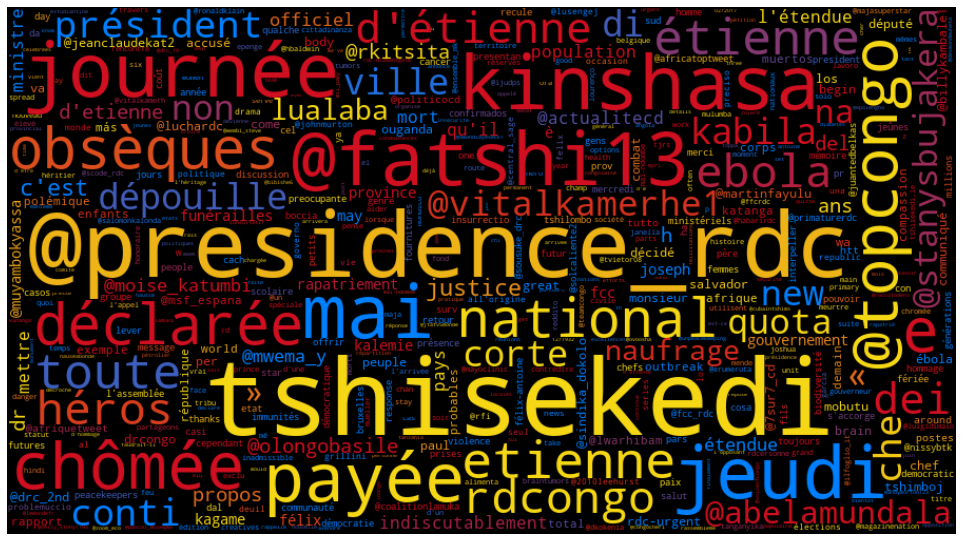

In [89]:
term_counts = get_term_count('../data/query_drc.jsonl')
word_cloud = generate_word_cloud(term_counts, drc_flag_color_map)
plot_word_cloud(word_cloud)

In [49]:
len(term_counts)

6015

#### VI. TWITTER TOPIC MODELING

In [50]:
import spacy
french_stematiser = spacy.load('fr')

Basically in this phase we wil train a machine learning model on our tweet to see which topics congoleses are talking about.

we will use co-occurence of word in a tweets , if word always appear together they form a topic.

We will use also the score of a word in a given topic to find the most relevants words in a given topic.

We wiil add another preprossesing step called stemming , stemming :
    
In the next step we stem the words in the list. This is essentially where we knock the end off the words. We do this so that similar words will be recognised as the same word by the algorithm

In [210]:
tokens = ['@lateamz', 'actualitecd', 'obsèques', 'etienne', 'tshisekedi', 'peter', 'kazadi', 'était', 'appelle', 'membres', 'udps', 'passer', 'querelles', 'intern']

let try spacy for stematisation.

In [211]:
#!pip install -U spacy

In [53]:
def stematise_token(tokens):
    """
    replace word in token list  with his lemma:
    example : appelais  will become appele, plural will be replaced by their singular version, etc
    """

    doc = french_stematiser(' '.join(tokens))
    return [token.lemma_ for token in doc]

let us remove other words we may find in the tweets such as congo, congolais, rdc, drc since we already knows that those words are related to congo

In [54]:
congo_words = {'congo', 'congolais', 'rdc', 'drc', '-', 'https'}
words_to_remove = words_to_remove.union(congo_words)

In [55]:
def prepocess_tweet(tweet):
    """
    Apply all the preprocessing process on a tweet and return the tweet as a text and tweet as list of tokens
    
    """
    text = tweet_preprocessor.clean(tweet.get('text'))
    text = text.replace('#', '')
    text = remove_emoji(text)
    tokens = process_text(text=text, tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
    tokens = stematise_token(tokens)
    return tokens

In [66]:
# this question will help when the df will grows https://stackoverflow.com/a/48287388/4683950

tweets_df = pd.DataFrame(columns=['cleanned_tweet'])
for tweet in read_tweets_file('../data/query_drc.jsonl'):
    tweets_df.loc[tweet.get('id')] = [' '.join(prepocess_tweet(tweet))]

In [68]:
tweets_df.head()

,cleanned_tweet
1133777552663818240,@africatoptweet alerte pratique montrer ds vid...
1133777552537997313,rdc - diamantgate ceec sankuru procureur génér...
1133777499874308098,@nissybtk salut année par décider offrir fourn...
1133777498293059584,@pascal_mulegwa corps de étienn tshisekedi qui...
1133777409256202240,président jk ramené ce être ce être féticheur ...


In [69]:
tweets_df.shape

(2000, 1)

The next step will be to apply now the algorithm and do topic modeling 

#### VI.b. sklearn phase 

To turn the text into a matrix*, where each row in the matrix encodes which words appeared in each individual tweet. We will also filter the words max_df=0.95 means we discard any words that appear in >90% of tweets. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=5, so words that appear in less than 25 tweets will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [71]:
vectorizer = CountVectorizer(max_df=0.95, min_df=5, token_pattern='\w+|\$[\d\.]+|\S+')
transfromed_tweets = vectorizer.fit_transform(tweets_df.get('cleanned_tweet')).toarray()

In [72]:
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [73]:
number_of_topics = 10
topic_modeling_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [74]:
topic_modeling_model.fit(transfromed_tweets)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [75]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [76]:
no_top_words = 10
display_topics(topic_modeling_model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,mai,29.4,@presidence_rdc,80.4,e,64.9,ebola,62.3,tshisekedi,57.7,futur,31.1,mai,84.5,tshisekedi,30.5,de,128.8,tshisekedi,39.4
1,',29.4,@vitalkamerhe1,47.1,dei,61.1,new,49.1,obsèque,44.9,kabila,24.5,payer,73.6,savoir,24.1,tshisekedi,120.7,étienne,26.7
2,tshisekedi,25.2,-,45.0,conti,57.1,na,44.1,de,42.8,national,23.5,le,67.9,ouganda,19.1,@fatshi13,71.6,begin,24.1
3,@drc_2nd,24.1,le,44.4,ville,53.1,may,23.9,etienne,42.4,peuple,22.1,jeudi,67.9,total,18.1,@presidence_rdc,67.2,wa,23.1
4,s,23.1,@fatshi13,40.9,di,51.7,salvador,22.1,le,29.3,le,20.4,-,62.0,prendre,17.1,etienne,58.5,brain,22.1
5,@luchardc,19.1,@mwema_y,32.1,cort,50.1,outbreak,19.1,kagame,25.1,fcc,20.1,chômé,56.3,le,15.3,@topcongo,55.9,@moise_katumbi,19.8
6,communiquer,19.1,naufrage,30.9,quota,48.1,star,14.1,paul,23.1,gouvernement,19.9,de,43.4,afrique,15.1,national,53.3,e,19.2
7,-,17.8,@abelamundala,30.1,étendu,48.1,thanks,14.1,_,15.3,@muyambokyassa,19.1,journer,42.1,étienne,15.1,«,42.0,petit,19.1
8,homme,17.1,etat,23.1,journée,40.9,come,14.1,annoncer,15.1,katanga,19.1,rdc,38.1,mettre,13.7,héros,41.2,décider,18.0
9,officiel,17.1,@billykambale1,22.1,tout,40.6,great,13.8,@politicocd,15.0,@presidence_rdc,18.7,déclaré,33.0,sud,13.1,étienn,40.7,combat,17.8


I think I have something to understand tommorrow moring ,
now I can level up on the others topics

In [77]:
topic_model_nmf = NMF(n_components=10, random_state=0, alpha=.1, l1_ratio=.5)

In [78]:
topic_model_nmf.fit(transfromed_tweets)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=10, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [79]:
no_top_words = 10
display_topics(topic_model_nmf, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,mai,2.5,tshisekedi,5.0,@presidence_rdc,3.8,dei,1.9,le,4.8,na,1.8,-,3.3,de,4.9,rdcongo,1.6,national,2.0
1,payer,2.5,etienne,1.3,@fatshi13,2.9,conti,1.8,que,0.6,new,1.8,naufrage,1.4,étienn,1.1,del,1.2,«,1.6
2,jeudi,2.2,étienne,1.2,@topcongo,1.4,cort,1.6,lualaba,0.6,salvador,1.6,e,1.2,dépouill,0.9,ébola,1.2,héros,1.6
3,chômé,2.1,obsèque,0.8,@vitalkamerhe1,1.3,quota,1.5,député,0.6,may,0.9,compassion,0.9,obsèque,0.7,los,1.2,»,1.5
4,journée,1.8,prendre,0.5,@abelamundala,1.2,e,1.4,il,0.6,star,0.8,féli,0.9,jeudi,0.6,muerto,1.2,etienne,1.5
5,déclaré,1.7,felix,0.5,@mwema_y,1.1,ch,1.0,justice,0.6,drama,0.8,antoin,0.9,kabila,0.5,@msf_espana,1.2,indiscutablement,1.3
6,tout,1.5,même,0.5,@billykambale1,0.8,',0.9,tshimboj,0.5,creative,0.8,message,0.9,@stanysbujakerer,0.5,probable,1.1,ministre,1.2
7,ville,1.3,contredir,0.5,kinshasa,0.5,che,0.8,assemblée,0.5,janella,0.8,etat,0.9,kinshaser,0.5,má,1.1,heure,1.2
8,étendu,1.3,option,0.5,@primaturerdc,0.4,se,0.7,être,0.5,joshua,0.8,rapport,0.8,an,0.4,caso,1.1,@olongobasile,1.2
9,kinshasa,1.1,utiliser,0.5,@olongobasil,0.4,all,0.7,prov,0.5,unit,0.8,tshilombo,0.8,se,0.4,casi,1.1,@topcongo,1.0
